Metrics on 100000 graphs:
  MSE (Absolute S): 0.000198
  MAE (Absolute S): 0.007279
  MAPE (Absolute S): 13.72%


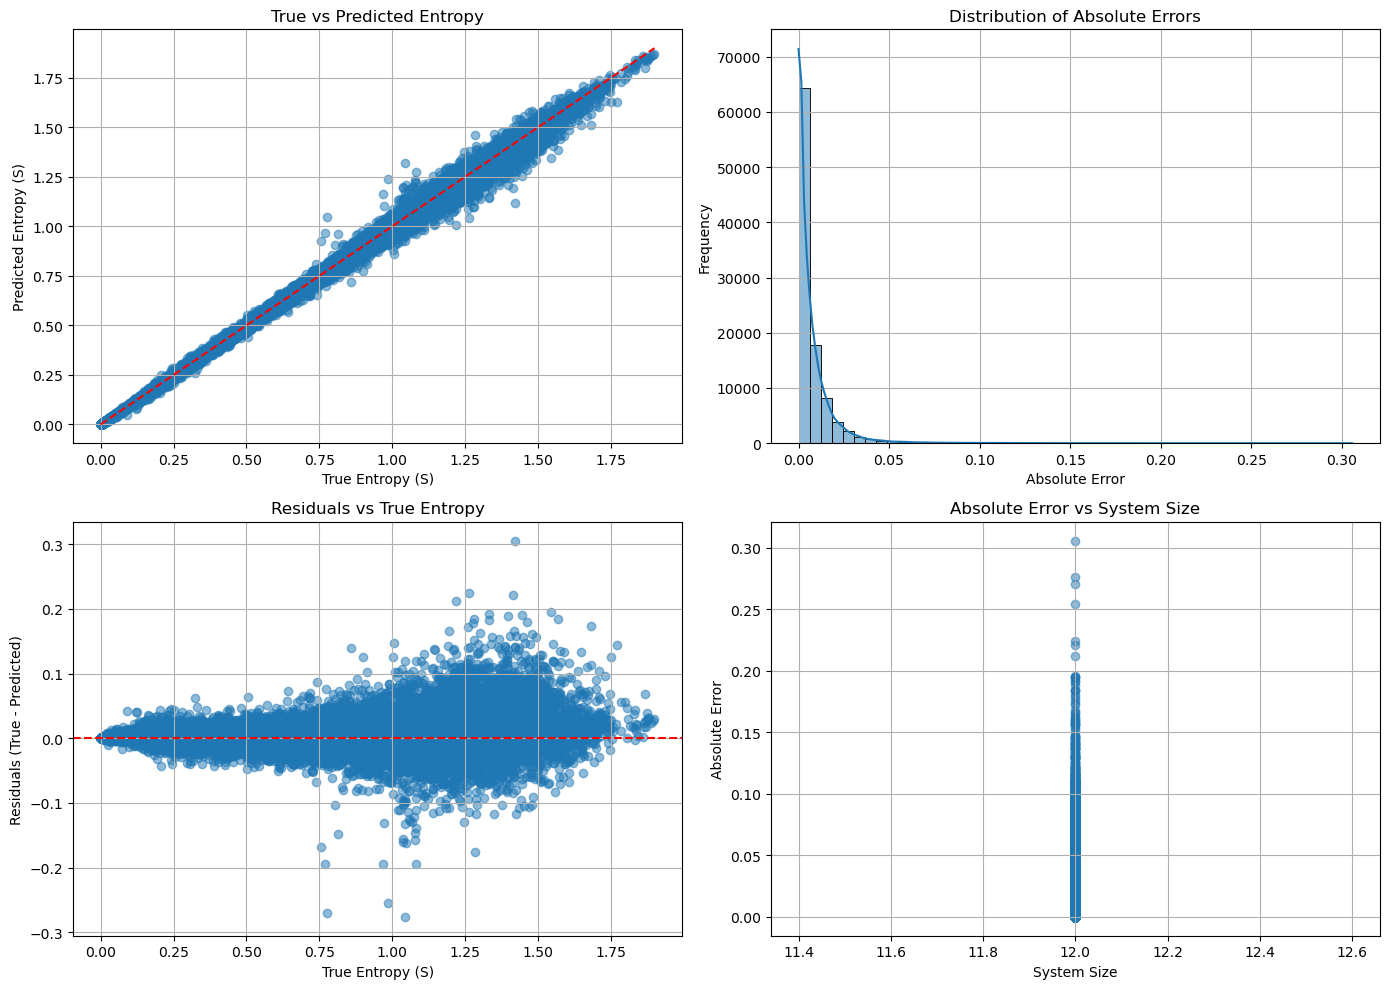

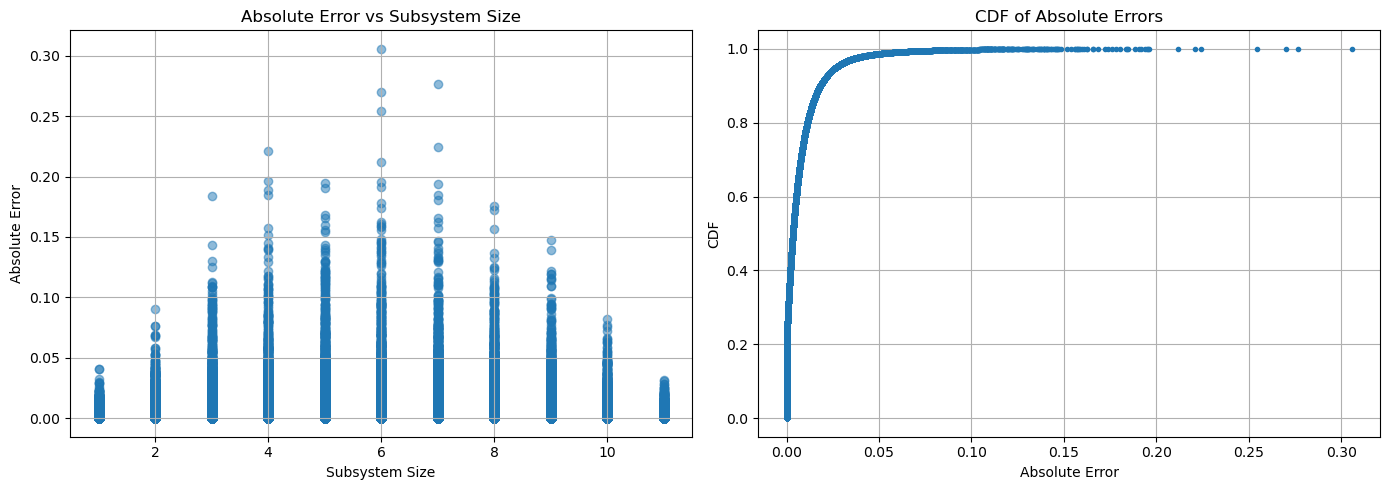

In [10]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch_geometric.utils import dropout_adj
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    BatchNorm,
    GATConv, 
    global_add_pool, 
    LayerNorm
)
from torch.utils.data import random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

CONFIG = {
    'processed_dir': './processed_experimental12',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'hidden_channels': 512,
    'num_epochs': 500,
    'patience': 75,
    'random_seed': 42,
    'best_model_path': 'best_model13.pth',
    'dropout_p': 0.4,
    'scheduler_factor': 0.5,
    'scheduler_patience': 10,
    'grad_clip': 1.0,
}



class SpinSystemDataset(InMemoryDataset):
    """Loads the data.pt from processed_dir (old-style)."""
    def __init__(self, root='.', transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [CONFIG['processed_file_name']]

    def download(self):
        pass

    def process(self):
        pass

class ExperimentalGNN(nn.Module):
    def __init__(self, hidden_channels=512, num_layers=8, dropout_p=0.4):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout_p = dropout_p

        self.feature_indices = {
            'position': slice(0, 2),
            'rydberg_val': 2,
            'mask': 3,
        }

        # Node and Edge Encoders
        self.node_encoder = nn.Sequential(
            nn.Linear(4, hidden_channels),
            LayerNorm(hidden_channels),
            nn.SiLU()
        )

        self.edge_encoder = nn.Sequential(
            nn.Linear(3, hidden_channels),
            LayerNorm(hidden_channels),
            nn.SiLU()
        )

        # Hierarchical Convolution Layers
        self.convs = nn.ModuleList()
        self.edge_convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(num_layers):
            if i % 2 == 0:
                # GINEConv with enhanced edge features
                mp_mlp = nn.Sequential(
                    nn.Linear(hidden_channels, hidden_channels),
                    LayerNorm(hidden_channels),
                    nn.SiLU(),
                    nn.Dropout(dropout_p),
                    nn.Linear(hidden_channels, hidden_channels)
                )
                conv = GINEConv(mp_mlp, edge_dim=hidden_channels)
            else:
                # TransformerConv with enhanced attention
                conv = TransformerConv(
                    hidden_channels,
                    hidden_channels // 8,
                    heads=8,
                    edge_dim=hidden_channels,
                    dropout=dropout_p,
                    beta=True,
                    concat=True
                )
            self.convs.append(conv)
            self.edge_convs.append(nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                LayerNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ))
            self.norms.append(LayerNorm(hidden_channels))

        # Hierarchical Pooling
        self.pool = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                LayerNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ) for _ in range(num_layers // 2)
        ])

        # Reduce number of readout heads and add dimension reduction
        self.readout = nn.ModuleList([
            Set2Set(hidden_channels, processing_steps=4) for _ in range(2)  # Reduced from 4 to 2 heads
        ])
        
        # Dimension reduction for readout outputs
        self.readout_projection = nn.Sequential(
            nn.Linear(4 * hidden_channels, 2 * hidden_channels),  # 4 = 2 heads * 2 (Set2Set doubles dim)
            LayerNorm(2 * hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p)
        )

        # Global Features MLP
        self.global_mlp = nn.Sequential(
            nn.Linear(2, hidden_channels),
            LayerNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels)
        )

        # Final MLP with corrected dimensions
        combined_dim = (2 * hidden_channels) + hidden_channels  # projected readout + global features
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_dim, hidden_channels),
            LayerNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels // 2),
            LayerNorm(hidden_channels // 2),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = (
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        # Node and Edge Feature Encoding
        node_features = torch.cat([
            x[:, self.feature_indices['position']],
            x[:, self.feature_indices['rydberg_val']].unsqueeze(-1),
            x[:, self.feature_indices['mask']].unsqueeze(-1),
        ], dim=1)

        edge_features = torch.stack([
            edge_attr[:, 0],
            edge_attr[:, 1],
            edge_attr[:, 2]
        ], dim=1)

        x_enc = self.node_encoder(node_features)
        e_enc = self.edge_encoder(edge_features)

        # Message Passing with Enhanced Edge Features
        h = x_enc
        for i in range(self.num_layers):
            # Update edge features
            e_enc = self.edge_convs[i](e_enc)
            # Perform convolution
            h_new = self.convs[i](h, edge_index, e_enc)
            h_new = self.norms[i](h_new)
            h = h + h_new  # Residual connection

            # Hierarchical Pooling with safety check
            if i % 2 == 0 and i // 2 < len(self.pool):
                h = self.pool[i // 2](h)

        # Multi-Head Readout with dimension reduction
        readouts = [readout(h, batch) for readout in self.readout]
        h_readout = torch.cat(readouts, dim=1)
        h_readout = self.readout_projection(h_readout)

        # Global Features
        nA_over_N = data.nA.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        nB_over_N = data.nB.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        global_feats = torch.stack([nA_over_N, nB_over_N], dim=1)
        gf_out = self.global_mlp(global_feats)

        # Combine features with correct dimensions
        combined = torch.cat([h_readout, gf_out], dim=1)
        out = self.final_mlp(combined).squeeze(-1)
        return out



# Load the trained model
def load_trained_model(model_path, hidden_channels=512, num_layers=8, dropout_p=0.4):
    model = ExperimentalGNN(
        hidden_channels=hidden_channels,
        num_layers=num_layers,
        dropout_p=dropout_p
    )
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


def evaluate_on_subset(model, dataset, N, batch_size=2048):
    subset = dataset[:N]  # Take the first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds_abs = []
    all_targets = []
    all_system_sizes = []
    all_subsystem_sizes = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred_entropy_abs = model(data)
            
            targets = data.y.squeeze()
            system_size = data.system_size.squeeze(-1)
            subsystem_size = data.nA.squeeze(-1)
            
            all_preds_abs.append(pred_entropy_abs.cpu())
            all_targets.append(targets.cpu())
            all_system_sizes.append(system_size.cpu())
            all_subsystem_sizes.append(subsystem_size.cpu())
    
    all_preds_abs = torch.cat(all_preds_abs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_system_sizes = torch.cat(all_system_sizes).numpy()
    all_subsystem_sizes = torch.cat(all_subsystem_sizes).numpy()
    
    # Calculate metrics
    mse_abs = mean_squared_error(all_targets, all_preds_abs)
    mae_abs = mean_absolute_error(all_targets, all_preds_abs)
    mape_abs = np.mean(np.abs((all_preds_abs - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics on {N} graphs:")
    print(f"  MSE (Absolute S): {mse_abs:.6f}")
    print(f"  MAE (Absolute S): {mae_abs:.6f}")
    print(f"  MAPE (Absolute S): {mape_abs:.2f}%")
    
    return all_preds_abs, all_targets, all_system_sizes, all_subsystem_sizes

def plot_results(preds, targets, system_sizes, subsystem_sizes):
    # Calculate residuals
    residuals = targets - preds
    abs_errors = np.abs(residuals)
    
    # Plot 1: True vs Predicted Entropy
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Predicted Entropy (S)')
    plt.title('True vs Predicted Entropy')
    plt.grid(True)
    
    # Plot 2: Error Distribution
    plt.subplot(2, 2, 2)
    sns.histplot(abs_errors, kde=True, bins=50)
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Absolute Errors')
    plt.grid(True)
    
    # Plot 3: Residual Plot
    plt.subplot(2, 2, 3)
    plt.scatter(targets, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Residuals (True - Predicted)')
    plt.title('Residuals vs True Entropy')
    plt.grid(True)
    
    # Plot 4: Error vs System Size
    plt.subplot(2, 2, 4)
    plt.scatter(system_sizes, abs_errors, alpha=0.5)
    plt.xlabel('System Size')
    plt.ylabel('Absolute Error')
    plt.title('Absolute Error vs System Size')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Additional Plots
    plt.figure(figsize=(14, 5))
    
    # Plot 5: Error vs Subsystem Size
    plt.subplot(1, 2, 1)
    plt.scatter(subsystem_sizes, abs_errors, alpha=0.5)
    plt.xlabel('Subsystem Size')
    plt.ylabel('Absolute Error')
    plt.title('Absolute Error vs Subsystem Size')
    plt.grid(True)
    
    # Plot 6: CDF of Absolute Errors
    plt.subplot(1, 2, 2)
    sorted_errors = np.sort(abs_errors)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
    plt.xlabel('Absolute Error')
    plt.ylabel('CDF')
    plt.title('CDF of Absolute Errors')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def main():
    # Configuration
    model_path = 'best_model13.pth'
    processed_dir = './processed_experimental12'
    N = 100000  # Number of graphs to evaluate on
    
    # Load the dataset
    dataset = SpinSystemDataset(root=processed_dir)
    
    # Load the trained model
    model = load_trained_model(model_path)
    
    # Evaluate on a subset of N graphs
    preds, targets, system_sizes, subsystem_sizes = evaluate_on_subset(model, dataset, N)
    
    # Plot the results
    plot_results(preds, targets, system_sizes, subsystem_sizes)

if __name__ == "__main__":
    main()


Processing...
Done!


Dataset length: 50000
Metrics on 5000 graphs:
  MSE: 0.002365
  MAE: 0.036776
  MAPE: 15.06%


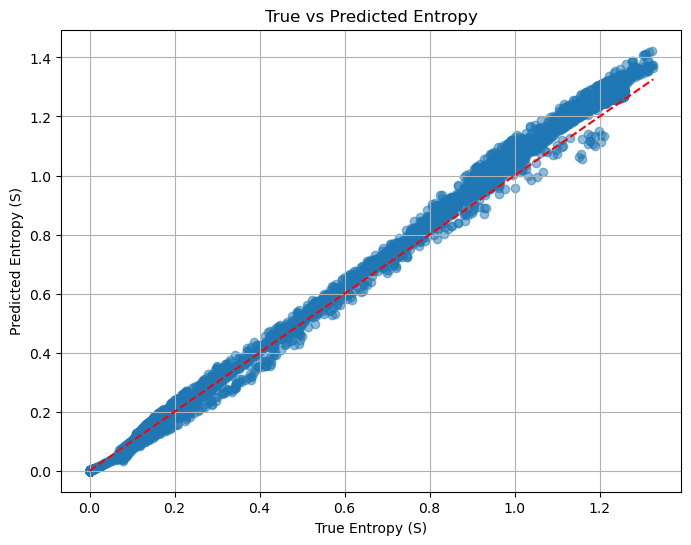

In [86]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.nn import (
    GINEConv,
    TransformerConv,
    Set2Set,
    LayerNorm
)
from torch.serialization import safe_globals

# For interactive 3D plotting with Plotly
import plotly.graph_objects as go

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CONFIG = {
    'processed_dir': './processed_experimentaltest3/processed',
    'processed_file_name': 'data.pt',
    'batch_size': 512,
    'hidden_channels': 512,
    'num_layers': 8,
    'dropout_p': 0.4
}

# -----------------------------------------------------------------------------
# Dataset Class (Loads Preprocessed Data)
# -----------------------------------------------------------------------------
class SpinSystemDataset(InMemoryDataset):
    def __init__(self, root='.', transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        # Load preprocessed data saved previously
        processed_path = os.path.join(root, CONFIG['processed_file_name'])
        self.data, self.slices = torch.load(processed_path, map_location=torch.device('cpu'),weights_only=False)
    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return [CONFIG['processed_file_name']]
    def download(self):
        pass
    def process(self):
        pass

def load_data():
    return SpinSystemDataset(root=CONFIG['processed_dir'])

# -----------------------------------------------------------------------------
# Model Definition
# -----------------------------------------------------------------------------
class ExperimentalGNN(nn.Module):
    def __init__(self, hidden_channels=512, num_layers=8, dropout_p=0.4):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout_p = dropout_p

        self.feature_indices = {
            'position': slice(0, 2),
            'rydberg_val': 2,
            'mask': 3,
        }

        self.node_encoder = nn.Sequential(
            nn.Linear(4, hidden_channels),
            LayerNorm(hidden_channels),
            nn.SiLU()
        )

        self.edge_encoder = nn.Sequential(
            nn.Linear(3, hidden_channels),
            LayerNorm(hidden_channels),
            nn.SiLU()
        )

        self.convs = nn.ModuleList()
        self.edge_convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(num_layers):
            if i % 2 == 0:
                mp_mlp = nn.Sequential(
                    nn.Linear(hidden_channels, hidden_channels),
                    LayerNorm(hidden_channels),
                    nn.SiLU(),
                    nn.Dropout(dropout_p),
                    nn.Linear(hidden_channels, hidden_channels)
                )
                conv = GINEConv(mp_mlp, edge_dim=hidden_channels)
            else:
                conv = TransformerConv(
                    hidden_channels,
                    hidden_channels // 8,
                    heads=8,
                    edge_dim=hidden_channels,
                    dropout=dropout_p,
                    beta=True,
                    concat=True
                )
            self.convs.append(conv)
            self.edge_convs.append(nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                LayerNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ))
            self.norms.append(LayerNorm(hidden_channels))

        self.pool = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                LayerNorm(hidden_channels),
                nn.SiLU(),
                nn.Dropout(dropout_p)
            ) for _ in range(num_layers // 2)
        ])

        self.readout = nn.ModuleList([
            Set2Set(hidden_channels, processing_steps=4) for _ in range(2)
        ])
        self.readout_projection = nn.Sequential(
            nn.Linear(4 * hidden_channels, 2 * hidden_channels),
            LayerNorm(2 * hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p)
        )

        self.global_mlp = nn.Sequential(
            nn.Linear(2, hidden_channels),
            LayerNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels)
        )

        combined_dim = (2 * hidden_channels) + hidden_channels
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_dim, hidden_channels),
            LayerNorm(hidden_channels),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels, hidden_channels // 2),
            LayerNorm(hidden_channels // 2),
            nn.SiLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Node feature encoding: use positions, Rydberg value, and mask.
        node_features = torch.cat([
            x[:, self.feature_indices['position']],
            x[:, self.feature_indices['rydberg_val']].unsqueeze(-1),
            x[:, self.feature_indices['mask']].unsqueeze(-1),
        ], dim=1)

        # Edge feature encoding (assumed to have 3 columns)
        edge_features = torch.stack([
            edge_attr[:, 0],
            edge_attr[:, 1],
            edge_attr[:, 2]
        ], dim=1)

        x_enc = self.node_encoder(node_features)
        e_enc = self.edge_encoder(edge_features)

        h = x_enc
        for i in range(self.num_layers):
            e_enc = self.edge_convs[i](e_enc)
            h_new = self.convs[i](h, edge_index, e_enc)
            h_new = self.norms[i](h_new)
            h = h + h_new  # Residual connection
            if i % 2 == 0 and i // 2 < len(self.pool):
                h = self.pool[i // 2](h)

        readouts = [readout(h, batch) for readout in self.readout]
        h_readout = torch.cat(readouts, dim=1)
        h_readout = self.readout_projection(h_readout)

        # Global features (using nA and system_size from the data)
        nA_over_N = data.nA.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        nB_over_N = data.nB.squeeze(-1) / (data.system_size.squeeze(-1) + 1e-10)
        global_feats = torch.stack([nA_over_N, nB_over_N], dim=1)
        gf_out = self.global_mlp(global_feats)

        combined = torch.cat([h_readout, gf_out], dim=1)
        out = self.final_mlp(combined).squeeze(-1)
        return out

# -----------------------------------------------------------------------------
# Model Loading (with safe unpickling)
# -----------------------------------------------------------------------------
def load_trained_model(model_path, hidden_channels=512, num_layers=8, dropout_p=0.4):
    model = ExperimentalGNN(hidden_channels=hidden_channels, num_layers=num_layers, dropout_p=dropout_p)
    with safe_globals([Data]):
        state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    model.eval()
    return model

# -----------------------------------------------------------------------------
# Evaluation Function
# -----------------------------------------------------------------------------
def evaluate_on_subset(model, dataset, N, batch_size=512):
    subset = dataset[:N]  # Evaluate on first N graphs
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    all_preds = []
    all_targets = []
    all_rb_over_a = []
    all_delta_over_omega = []
    all_mutual_info = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            
            targets = data.y.squeeze()            # True von Neumann entropy
            rb_over_a = data.rb_over_a.squeeze(-1)   # Feature: Rb/a
            delta_over_omega = data.delta_over_omega.squeeze(-1)  # Feature: Δ/Ω
            mutual_info = data.MI.squeeze(-1)       # Mutual Information
            
            all_preds.append(pred.cpu())
            all_targets.append(targets.cpu())
            all_rb_over_a.append(rb_over_a.cpu())
            all_delta_over_omega.append(delta_over_omega.cpu())
            all_mutual_info.append(mutual_info.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_rb_over_a = torch.cat(all_rb_over_a).numpy()
    all_delta_over_omega = torch.cat(all_delta_over_omega).numpy()
    all_mutual_info = torch.cat(all_mutual_info).numpy()
    
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    mape = np.mean(np.abs((all_preds - all_targets) / (all_targets + 1e-10))) * 100
    
    print(f"Metrics on {N} graphs:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return all_preds, all_targets, all_rb_over_a, all_delta_over_omega, all_mutual_info

# -----------------------------------------------------------------------------
# Plotting Functions
# -----------------------------------------------------------------------------
def plot_results(preds, targets):
    residuals = targets - preds
    abs_errors = np.abs(residuals)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, preds, alpha=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.xlabel('True Entropy (S)')
    plt.ylabel('Predicted Entropy (S)')
    plt.title('True vs Predicted Entropy')
    plt.grid(True)
    plt.show()

def plot_3d_overlay_interactive(rb_over_a, delta_over_omega, targets, preds, mutual_info,
                                save_html=False, html_filename='3d_overlay.html'):
    """
    Create an interactive 3D scatter plot overlaying the three series.
    Use save_html=True to save the plot as an HTML file.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=rb_over_a, y=delta_over_omega, z=targets,
        mode='markers',
        marker=dict(size=4, color='blue'),
        name='True Entropy'
    ))
    fig.add_trace(go.Scatter3d(
        x=rb_over_a, y=delta_over_omega, z=preds,
        mode='markers',
        marker=dict(size=4, color='red'),
        name='Predicted Entropy'
    ))
    fig.add_trace(go.Scatter3d(
        x=rb_over_a, y=delta_over_omega, z=mutual_info,
        mode='markers',
        marker=dict(size=4, color='green'),
        name='Mutual Information'
    ))
    fig.update_layout(
        width=900,       # Adjust width (pixels) as desired
        height=700,      # Adjust height (pixels) as desired
        scene=dict(
            xaxis_title='Rb/a',
            yaxis_title='Δ/Ω',
            zaxis_title='Value'
        ),
        title="Overlayed 3D Scatter: True vs Predicted Entropy & MI"
    )
    if save_html:
        fig.write_html(html_filename)
        print(f"Interactive plot saved as {html_filename}")
    else:
        fig.show()

# -----------------------------------------------------------------------------
# Main Function
# -----------------------------------------------------------------------------
def main():
    model_path = 'best_model13.pth'
    N = 5000  # Number of graphs to evaluate
    
    dataset = load_data()
    print(f"Dataset length: {len(dataset)}")
    
    model = load_trained_model(model_path)
    preds, targets, rb_over_a, delta_over_omega, mutual_info = evaluate_on_subset(model, dataset, N)
    
    plot_results(preds, targets)

    plot_3d_overlay_interactive(rb_over_a, delta_over_omega, targets, preds, mutual_info, save_html=False)

if __name__ == "__main__":
    main()
